# ECE 143 Individual Project Spring Quarter 2018
*by Humberto Hernandez*

Note: Please run all the code in this notebook once by going to *Cell --> Run All*

## Project Description
This project is for the planning of an ad-hoc communications network over a large rectangular region.
Towers are represented by rectangular regions and must be generated at random. No overlap between to rectangular regions is allowed. The following rules apply.
1. All rectangular sections have integer-based corners.
2. All rectangular sections must be contained in the overall rectangular footprint.
3. The height and width of each rectangular section must be sampled from a uniform distribution.
4. Positions of the windows are also determined by uniform distribution.
5. All footprints must be rectangles (no general polygons).
6. When a new tower comes online, if its coverage rectangle intersects the pre-existing composite footprint
    then that new tower's coverage is trimmed such that it's maximum remaining coverage is retained.
    
Implement a solution to this problem such that a user can supply the overall size of the desired coverage
footprint and then determine the following.
1. Given an overall desired coverage footprint and a sequence of n communications towers,
    what is the resulting resolved coverage?
2. What is the total area relative to the desired total coverage area of the original footprint?
    That is, are there any gaps in coverage?
3. On average, how many communications towers are required before full coverage is obtained?

## What is in this notebook
This Juypter Notebook will explain the individual components of the code as well as the thought process in how I chose to implement certain solutions to solve specific types of problems.

## Visualizing The Towers
Before I began, I realized that it would be somewhat difficult to code the solution without having a way of being able to visualize the process beforehand. I needed something that could take the desired coverage area so that I could visualize it. So I began by first creating the layout of that area.

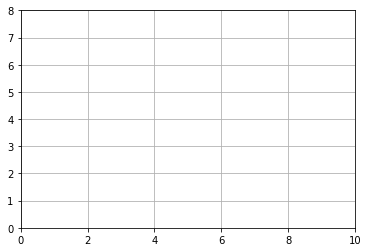

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
width = 10
height = 8
fig2 = plt.figure() #Returns the figure.
ax2 = fig2.add_subplot(111) #Returns the axes. Have to use subplot to get the patches attribute.
ax2.set_xlim(0,width) #Sets the x-axis.
ax2.set_ylim(0,height) #Sets the y-axis.
plt.grid() #Setting up a grid for better clarity

Now that I had a way of viewing the desired coverage area, I needed a way to be able to view the towers. So I searched and I found something called *matplotlib.patches* which allows us to be able to plot a tower by representing it as its coverage area. It has a class called *Rectangles* which allows one to plot a rectangle by setting an (x,y) coordinate for its lower left corner as a tuple, its width, and height. 

*Based on information found at*
1. Python Patterns - matthiaseisen.com/pp/patterns/p0203
2. set_xlim - https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.set_slim.html#matplotlib.axes.Axes.set_xlim
3. subplot - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot

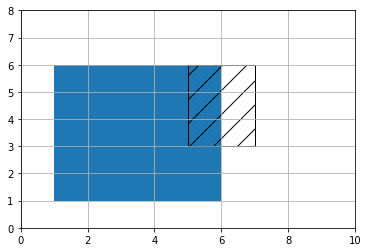

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
width = 10
height = 8
fig2 = plt.figure() #Returns the figure.
ax2 = fig2.add_subplot(111) #Returns the axes. Have to use subplot to get the patches attribute.
ax2.set_xlim(0,width) #Sets the x-axis.
ax2.set_ylim(0,height) #Sets the y-axis.
plt.grid() #Setting up a grid for better clarity
ax2.add_patch(patches.Rectangle((1,1),5,5)) #(x,y),width,height. Adding arbitrary rectangle.
ax2.add_patch(patches.Rectangle((5,3),2,3,fill = False, hatch = '/')) #(x,y),width,height. Adding arbitrary rectangle.

And to this I would be adding more and more boxes as my code begins to run.

Now that I have a way of visualizing what's going on, I can begin on how to actually address the problem stated in the project description.

## The Tower Class
Now that there is a way to visualize the things that are going on in the code, I can create a class that would make sense for this project.

When coming up with a class for this project, there were certain things that I wanted when defining a tower. So essentially, I started off with deciding what kind of data I would like to associate with a tower.
1. Coordinates. Whether that'd be coordinates for one corner or all four corners.
2. Width.
3. Height.
4. Area.

*Note: I'm using the term height because length and width are interchangeable in my mind and I often get them confused.*

So below is the code that I made for the class listing these things. If you are familiar with classes, then most of this is self explanatory. I begin by using the init method to set the lower left corner, the width, and height. At first, I was going to define the other corners and area in the init method as well, but I realized something that I might encounter later. If I had defined these in the init method, if I were to modify some values, the other three corners and the area would not update with the current values. So with the use of class methods and the *@property* decorator, I'm able to always have access to updated values. That way everything stays updated and consistent.

I would like to explain the rest of the methods, but in order to do that, we need to create a more robust visualization, because it is easier to describe visually then to explain it. In fact, most of this project involved me drawing in my notebook trying to figure out certain edge cases.

So lets run bring in the entire class just so we have it available and then we can explain how the different methods available for the class work.

In [3]:
#Author: Humberto Hernandez
#Last Updated: 5/19/2018 5:46pm
import itertools as it

class tower(object):
    '''
    Produces a tower object.
    
    Attributes:
        - self.coord_xx = (x,y), where xx is the subscript corresponding to a corner
            of the tower's coverage area.
            - ll means lower left corner.
            - lr means lower right corner.
            - tl means top left corner.
            - tr means top right corner.
        - self.width = Width of coverage area.
        - self.height = Height of the coverage area.
        - self.area = Area of coverage area.

    Attribute Type:
        - self.coord_xx is a tuple of size two with integer arguments corresponding
            to the (x,y) location of that corner.
                e.g. self.coord_ll = (0,0)
        - self.width is type int.
        - self.height is type int.
        - self.area is type int.
        
    Methods:
        - coord_lr(),coord_tl(),coord_tr() give corresponding (x,y) coordingates
            for specified corner. These are methods that have property decorators
            so they can be referenced by the user as attributes.
        - __eq__: Checks whether two towers are equivalent to each other.
        - __repr__:  Returns the string representation of tower object.
        - contained(): Checks which corners of a tower are contained in another
                        tower's coverage area.
        - corner(): Checks which corners of a tower are contained in another
            tower's coverage area.
        - overlap(): Returns sub-tower with largest overlap with other.
        - truncate(): Takes in a tower and a list of towers and truncates the
                        tower versus that list. 
        - borders(): Checks which walls of a tower overlap another tower's
                        coverage area.
        - subtowers(): Returns a list of a possible sub-towers for a given tower.
        
    '''
    
    def __init__(self,coord,width,height):
        '''
        Creates self.width, self.height, and coord_ll upon instance creation of
        tower.
        
        Parameter: self
        Type: Instance of tower class.
        
        Parameter: coord
        Type: tuple of length 2, items in tuple must be integer.
        
        Parameter: width
        Type: int
        
        Parameter: height
        Type: int 
        
        Returns:
            - self.width = width
            - self.height = height
            - self.coord_ll = coord
            
        Assertions:
            - (x,y) coordinate must be a tuple.
            - Length of tuple must be 2.
            - width, height, x, and y must be greater than zero.
            - x and y coordinates must be integers.
            - width and height must be integers.
        
        '''
        assert isinstance(coord,tuple), 'Warning! (x,y) must be a tuple.'
        assert len(coord) == 2, 'Warning! Only a tuple of length two!'
        assert width > 0, 'Warning! tower width must be greater than zero!'
        assert height > 0, 'Warning! tower height must be greater than zero!'
        assert (coord[0] >= 0) and (coord[1] >= 0), 'Warning! Coordinates must be positive.'
        assert isinstance(coord[0],int) and isinstance(coord[1],int),'Coordinates must be integers.'
        assert isinstance(width,int), 'Warning! Must be int!'
        assert isinstance(height, int), 'Warning! Must be int!'

        self.width = width
        self.height = height
        self.coord_ll = coord                           #Lower left corner
 
    #In the event that something gets updated, these will always
    #update with the most recent values.    
    @property
    def coord_lr(self): #Lower Right Corner
        '''
        Returns lower right corner of tower's coverage area as an (x,y) tuple
        
        Parameter: The instance of the tower being used to call this method is
                    referred to as self.
        Type: Instance of class tower.
        
        Return: (x,y) tuple for the lower right corner of tower's coverage area.
        
        e.g. 
        >>> t = tower((1, 2),6,4)
        >>> t.coord_lr
        (7,2)
                    
        Returns the lower right corner of a tower's coverage area by taking
        the width and adding it to the x-value of the of the tower object's
        lower left corner (self.coord_ll[0]) attribute's x-coordinate.
        
        Assertions:
            - Can only be used on an instance of tower class.
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        return (self.coord_ll[0] + self.width, self.coord_ll[1])
        
    @property #Top Left Corner
    def coord_tl(self):
        '''
        Returns top left corner of tower's coverage area as an (x,y) tuple
        
        Parameter: The instance of the tower being used to call this method is
                    referred to as self.
                    
        Type: Instance of class tower.
        
        Return: (x,y) tuple for the top left corner of tower's coverage area.
        
        e.g. 
        >>> t = tower((1, 2),6,4)
        >>>> t.coord_lr
        (1,6)
                    
        Returns the top left corner of a tower's coverage area by taking
        the height and adding it to the y-value of the of the tower object's
        lower left corner (self.coord_ll[1]) attribute's y-coordinate.
        
        Assertions:
            - Can only be used on an instance of tower class.
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        return (self.coord_ll[0], self.coord_ll[1] + self.height)
    
    @property
    def coord_tr(self): #Top Right Corner
        '''
        Returns top right corner of tower's coverage area as an (x,y) tuple
        
        Parameter: The instance of the tower being used to call this method is
                    referred to as self.
                    
        Type: Instance of class tower.
        
        Return: (x,y) tuple for the top right corner of tower's coverage area.
        
        e.g. 
        >>> t = tower((1, 2),6,4)
        >>> t.coord_lr
        (7,6)
                    
        Returns the top right corner of a tower's coverage area by taking
        the height and adding it to the y-value of the of the tower object's
        lower left corner (self.coord_ll[1]) attribute's y-coordinate as well as
        taking the width and adding it to the tower object's lower left corner
        (self.coord_ll[0]) attribute's x-coordinate.
        
        Assertions:
            - Can only be used on an instance of tower class.
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        return (self.coord_ll[0] + self.width, self.coord_ll[1] + self.height)

    @property
    def area(self): #Coverage area of tower
        '''
        Returns the area of the tower's coverage area.
        
        Parameter: The instance of the tower being used to call this method is
                    referred to as self.
                    
        Type: Instance of class tower.
        
        Return: Returns an integer value for the area.
        
        e.g. 
        >>> t = tower((1, 2),6,4)
        >>> t.area
        24
        
        Returns the area for a given tower object by taking the tower's width 
        (self.width) and a tower's height (self.height) and taking the product.
        
        self.area = self.width * self.height
        
        Assertions: 
            - Can only be used on an instance of tower class.
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        return self.width * self.height
    
    def __repr__(self):
        '''
        Returns tower object in string format so as to easily reproduce the tower object.
        
        e.g.
        >>> t = tower((1, 2),6,4)
        >>> print t
        tower((1, 2),6,4)
        
        Assertions:
            - Can only be used on an instance of tower class.
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        return 'tower(%s,%d,%d)' % (self.coord_ll,self.width,self.height)
            
    def contained(self,other):
        '''
        Checks which corners of a tower (referred to as self) are contained in 
        another tower's (referred to as other) coverage area.
        
        Parameter: self
        Type: tower object
        
        Parameter: other
        Type: tower object
        
        Returns: A list of True or False boolean values. Where each item in the 
        list corresponds to a corner in the following manner.
        
                [LowerLeftCorner,TopLeftCorner,LowerRightCorner,TopRightCorner]
        
        A corner produces a True value if it is inside other's coverage area.
        If the whole list is True, then that means the tower is contained.
        Any Falses mean that the corresponding corner lies outside the bounds 
        of the other's coverage area.
        
        e.g.
        
        >>> t = tower((0,0),2,2)
        >>> z = tower((1,1),2,2)
        >>> z.contained(t) 
        [True, False, False, False]
        >>> #Tells us that the lower left corner is inside t's coverage.
        
        It does so by checking each corner of a tower's (referred to as self)
        coverage area. For each corner it checks it against the corners of
        the other tower's (referred to as other) coverage area. It does so by
        accessing the attributes (coord_ll,coord_tl,coord_lr,coord_tr) of other's
        coverage area and checking against the x-coordinate and y-coordinate of
        each of other's corner. If one of self's corners is bounded inside by
        other's corners, then that corner is indeed contained and produces 
        a value of True. Else it produces False.
        
        Note: The corner method INCLUDES the bounds created by other's four
                corners
        
        Assertions:
            - Method can only be used on instances of tower class.
            
        '''
        assert isinstance(other,tower),'Warning! Argument is not of class tower!'
        assert isinstance(self,tower), 'Warning! Argument is not of class tower!'
        checker = [False,False,False,False] #Corners = [lowerleft,TopLeft,lowerRight,TopRight]
        if (self.coord_ll[0] >= other.coord_ll[0]) and (self.coord_ll[1] >= other.coord_ll[1]):
            checker[0] = True
        if (self.coord_tl[0] >= other.coord_tl[0]) and (self.coord_tl[1] <= other.coord_tl[1]):
            checker[1] = True
        if (self.coord_lr[0] <= other.coord_lr[0]) and (self.coord_lr[1] >= other.coord_lr[1]):
            checker[2] = True
        if (self.coord_tr[0] <= other.coord_tr[0]) and (self.coord_tr[1] <= other.coord_tr[1]):
            checker[3] = True
            
        return checker
    
    def __eq__(self,other):
        '''
        Checks if one tower is equivalent to another.
        
        Parameter: self
        Type: tower object
        
        Parameter: other
        Type: tower object
        
        Returns: True or False.
        
        e.g.
        >>> t = tower((0,0),2,2)
        >>> z = tower((0,0),2,2)
        >>> t == z
        True
        
        Returns True or False if a tower is equivalent to another tower.
        It does so by checking if the lower left coordinate's, the heights,
        and the widths of both towers match.
        - self.coord_ll == other.coord_ll
        - self.width == other.width
        - self.height == other.height
        
        Assertions:
            - Method can only be used on instances of tower class.
            
        '''
        assert isinstance(self,tower)
        assert isinstance(other,tower)
        if(self.coord_ll == other.coord_ll) and (self.width == other.width) and (self.height == other.height):
            return True
        else: 
            return False
    
    def corner(self,other):
        '''
        Checks which corners of a tower are in another tower's coverage area.
        Ignores the bounds of the other tower's coverage area.
        
        Parameter: self
        Type: tower object
        
        Parameter: other
        Type: tower object
        
        Return: A list with four boolean values, each corresponding to a corner of
                the tower (referred to as self), that is inside the tower is is
                being compared to (referred to as other.)
                
                [lowerleftcorner,TopLeftcorner,lowerRightcorner,TopRightcorner]
        
        e.g.
        
        >>> t = tower((0,0),2,2)
        >>> z = tower((1,1),2,2)
        >>> z.corner(t) 
        [True, False, False, False]
        >>> #Tells us that the lower left corner is inside t's coverage.
        
        It does so by checking each corner of a tower's (referred to as self)
        coverage area. For each corner it checks it against the corners of
        the other tower's (referred to as other) coverage area. It does so by
        accessing the attributes (coord_ll,coord_tl,coord_lr,coord_tr) of other's
        coverage area and checking against the x-coordinate and y-coordinate of
        each of other's corner. If one of self's corners is bounded inside by
        other's corners, then that corner is indeed contained and produces 
        a value of True. Else it produces False.
        
        The following variables in the code all have the same list convention.
        
        corners, checkers, results = [lowerleftcorner,TopLeftcorner,lowerRightcorner,TopRightcorner]
        
        Note: The corner method EXCLUDES the bounds created by other's four
                corners
 
       Assertions:
            - Method can only be used on instances of tower class.
                            
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        assert isinstance(other,tower), 'Warning! Argument must be of class tower!'
        corners = [self.coord_ll,self.coord_tl,self.coord_lr,self.coord_tr]
        results = [] #The result of a corner.
        for corner in corners:
            checkers = [False,False,False,False]
            if (corner[0] > other.coord_ll[0]) and (corner[1] > other.coord_ll[1]):
                checkers[0] = True
            if (corner[0] > other.coord_tl[0]) and (corner[1] < other.coord_tl[1]):
                checkers[1] = True
            if (corner[0] < other.coord_lr[0]) and (corner[1] > other.coord_lr[1]):
                checkers[2] = True
            if (corner[0] < other.coord_tr[0]) and (corner[1] < other.coord_tr[1]):
                checkers[3] = True

            if all(checkers):
                results.append(True)
            else:
                results.append(False)
                
        return results
    
    def subtowers(self):
        '''
        Returns a generator object that produces all possible subtowers for a 
        given tower. Starts with subtowers with the largest area and goes down 
        to the subtowers with the smallest area.
        
        Parameter: self
        Type: tower object
        
        Return: generator object that produces a tower's sub-towers.
        
        e.g.
        >>> t = tower((0,0),2,2)
        >>> x = t.subtowers()
        >>> x
        <generator object subtowers at 0x000000000D9B6870>
        >>> for i in x:
        ...    print i
        ...
        tower((0, 0),2,2)
        tower((0, 0),1,2)
        tower((1, 0),1,2)
        tower((0, 0),2,1)
        tower((0, 1),2,1)
        tower((0, 0),1,1)
        tower((1, 0),1,1)
        tower((0, 1),1,1)
        tower((1, 1),1,1)
        
        It starts by taking the tower's width, height, and lower left corner value
        and constructing lists of all possible widths,heights, x-coordinates,
        and y-coordinates. Then it concatenates the widths and heights in order
        to use the product function from the itertools module to produce all
        possible width and height pairs into a list of tuples. It removes the 
        duplicates in this list. We then sort the width and height pairs by
        ordering them from the largest area to the smallest area that a pair
        can produce by the use of the built-in sort function found in Python and
        the use of a lambda function in it's argument. This helps avoid having
        to compute a large list which can reach millions of subtowers long if the
        desired coverage area is large enough.
        
        Assertions:
            - Can only be used on an instance of tower class.        
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        #Range of coordinate values possible within the current towers coverage area.
        coord_x_list = range(self.width)
        coord_y_list = range(self.height)
        
        #Possible x-values and y-values inside the tower's coverage area.
        tower_xs = [i+self.coord_ll[0] for i in coord_x_list]
        tower_ys = [i+self.coord_ll[1] for i in coord_y_list]
        
        #Range of possible tower widths and heights possible within tower's coverage area.
        w = range(self.width)
        h = range(self.height)
        tower_ws = [i+1 for i in w]
        tower_hs = [i+1 for i in h]
        
        tower_width_height = tower_hs + tower_ws
        
        width_height_pairs = []
        for product in it.product(tower_width_height,repeat = 2):
            width_height_pairs.append(product)
            
        unique_pairs = list(set(width_height_pairs))
        
        #Ordering from largest area to smallest.
        unique_pairs.sort(key = lambda (a,b): a*b, reverse = True)
        
        for width,height in unique_pairs:
            for y in tower_ys:
                for x in tower_xs:
                    t = tower((x,y),width,height)
                    if all(t.contained(self)):
                        yield t
                    else:
                        break
                                     
        
    def overlap(self,other):
        '''
        Returns the overlap of one tower with another tower as a tower
        object. If no overlap is possible, returns None.
        
        Parameter: self
        Type: tower object
        
        Parameter: other
        Type: tower object
        
        Return: tower object representing the region of overlap.
                If no overlap is found, returns None.
                
        e.g.
        >>> t = tower((0,0),2,2)
        >>> z = tower((1,1),2,2)
        >>> z.overlap(t)
        tower((1, 1),1,1)
        
        Returns the region of overlap by looking for the largest subtower that
        can represent the region of overlap. Due to the fact that when using 
        the subtowers() method, it produces the subtowers with the largest area
        first, that means that the first subtower that, when run through the
        contained method, produces all true, then it would be equal to the region
        of overlap. The use of the generator makes the computation quick. It can
        find the overlap without having to generate all possible subtowers.

       Assertions:
            - Method can only be used on instances of tower class. 
            
       '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        assert isinstance(other,tower), 'Warning! Argument must be of class tower!'               

        subtowers = self.subtowers()

        for subtower in subtowers:
            contained_check = subtower.contained(other)
            if all(contained_check):
                return subtower
            
        return None
    
    def borders(self,other):
        '''
        Returns whether the left, right, top, or bottom wall of a tower (self) overlaps
        with another tower's (other).
        
        Parameter: self
        Type: tower object
        
        Paramater: other
        Type: tower object
        
        Return: A boolean list with values corresonding to a wall in the following 
                format. True means that the wall is inside another tower's coverage area.
                False means that is is not between the other tower's walls.
                
                [Left Wall, Right Wall, Top Wall, Bottom Wall]
                
        e.g.
        >>> t = tower((0,0),2,2)
        >>> z = tower((1,1),2,2)
        >>> z.borders(t)
        [True, False, False, True] #Left wall and bottom wall are inside.
        
        It does so by checking each wall individually. For the left and right walls,
        it checks whether the x-coordinates of those walls can be found inside
        the region bounded between other's left and right walls. If is found within
        this region of x-values, it then checks whether the y-values of self's left
        and right walls are found in the region bounded by other's y-values of
        the left and right walls. The top and bottom walls are computed in a similar
        fashion.
        
        Assertions:
            - Method can only be used on instances of tower class. 
            
        '''
        assert isinstance (self,tower), 'Warning! Requires an instance of tower class!'
        assert isinstance(other,tower), 'Warning! Argument must be of class tower!'
        wall = [False, False, False, False] #[left wall, right wall, top wall, bottom wall]
        #Start with left wall.
        if (self.coord_ll[0] < other.coord_lr[0]) and (self.coord_ll[0] >= other.coord_ll[0]):
            if (self.coord_ll[1] < other.coord_tl[1]) and (self.coord_ll[1] >= other.coord_ll[1]):
                wall[0] = True
            elif (self.coord_ll[1] < other.coord_ll[1]) and (self.coord_tl[1] > other.coord_ll[1]):
                wall[0] = True
        #Check right wall.
        if (self.coord_lr[0] > other.coord_ll[0]) and (self.coord_lr[0] <= other.coord_lr[0]):
            if (self.coord_lr[1] < other.coord_tr[1]) and (self.coord_lr[1] >= other.coord_lr[1]):
                wall[1] = True
            elif (self.coord_lr[1] < other.coord_lr[1]) and (self.coord_tr[1] > other.coord_lr[1]):
                wall[1] = True  
        #Checking top wall.
        if(self.coord_tl[1] > other.coord_ll[1]) and (self.coord_tl[1] <= other.coord_tl[1]):
            if (self.coord_tl[0] < other.coord_lr[0]) and (self.coord_ll[0] >= other.coord_ll[0]):
                wall[2] = True
            elif (self.coord_tl[0] < other.coord_ll[0]) and (self.coord_tr[0] > other.coord_ll[0]):
                wall[2] = True
        #Checking lower wall        
        if(self.coord_ll[1] < other.coord_tl[1]) and (self.coord_ll[1] >= other.coord_ll[1]):
            if (self.coord_ll[0] < other.coord_tr[0]) and (self.coord_ll[0] >= other.coord_ll[0]):
                wall[3] = True
            elif (self.coord_ll[0] < other.coord_ll[0]) and (self.coord_lr[0] > other.coord_ll[0]):
                wall[3] = True
        return wall

    def truncate(self,other):
        '''
        Takes in a list of towers (other) to truncate against and returns a single tower
        object, optimizing new tower for maximum possible area.
        
        Parameter: self
        Type: tower object
        
        Parameter: other
        Type: list, items in this list must be type tower object.
        
        Return: tower object representing truncated version of self maximized
                for largest possible area. If no valid truncated version exists
                against towers found in the list, returns None. If tower does not
                overlap with any found in the list, returns itself.
        
        e.g.
        >>> t = tower((0,0),2,2)
        >>> z = tower((1,1),2,2)
        >>> z.truncate([t])
        tower((2, 1),1,2)
        
        It starts by calling the subtowers() method on self. It starts checking
        subtowers (starting with the largest area) and checks them against all
        towers found in the list (other). It only returns a the best truncated
        version if it passes both the corner method and the border method with
        values of all Falses (meaning not found inside the tower's we are
        checking against) for all towers found in the list (other).
        
        Assertions:
            - Can only be used with tower objects.
            - List argument must be a list.
            - Arguments inside of list must be of class tower. Validated
                within corner and borders method.
        '''
        assert isinstance(other,list), 'Warning! Argument must be type list!'
            
        subtowers = self.subtowers()
        
        default = None
        
        for subtower in subtowers:
            valid = 1
            for tower in other:
                corner_check = subtower.corner(tower)
                border_check = subtower.borders(tower)
                if (any(corner_check)) or (any(border_check)):
                    valid = 0
                    break
            if valid == 1:
                #Only returns subtower if it's valid subtower for all towers it is checking against.
                return subtower
        
        return default             

This tower class has all the information I would need to know for any given tower. Note, the (x,y) coordinate used to create a tower is for the lower left corner of the tower's coverage area.

In [4]:
t = tower((1,1),2,3)

print 't.coord_ll: ', t.coord_ll  #Lower left corner coordinate of tower coverage
print 't.coord_lr: ', t.coord_lr   #Lower right corner coordinate of tower coverage
print 't.coord_tl: ', t.coord_tl   #Top left corner coordinate of tower coverage
print 't.coord_tr: ', t.coord_tr   #Top right corner coorfinate of tower coverage
print 't.area: ', t.area           #Area of tower's coverage

t.coord_ll:  (1, 1)
t.coord_lr:  (3, 1)
t.coord_tl:  (1, 4)
t.coord_tr:  (3, 4)
t.area:  6


## Visualization
Now that we have the class available to work with, we can bring in the visualization aspect of the project, which helped me to see what was going on.

I created a function that would plot the desired coverage area and the towers that are placed within that coverage area. There a couple of ways to customize the plot that I went in detail in the documentation. The important thing that this code allows me to do is I can give it a list of tower objects with details on what facecolor I want it to have as well as a hatch type.

In [5]:
def plot_towers(towers,width,height):
    '''
    Takes in a list of towers describing there facecolor and hatch type and returns
    a single plot with them on it.
    
    Parameters:
        - towers is a lists of lists, where each sub list contains a tower object,
            facecolor in RGB-hexadecimal format, and hatch type, and fill.
            
            e.g. [tower((1,1),2,3), #0000ff, '-', True]
            
        - width and height describe the bounds of the plotting area. In reference
            to this project, it describes the individual plotting area.
        - rgb color must be in the following format 
            #xxxxxx, where x is a number ranging from 0-9 or a letter ranging from
            a-f.
        - fill determines whether a towers box has color or is transparent. Can be
            True or False. True for color, False for transparent.
        
    Type: 
        - towers: list
        - width:  int
        - height: int
    
    Note: - Imports the matplotlib module as well as the patches module. Makes use
            of the Rectangle class to create the coverage area of each tower.
          - Requires the tower class.  
    
    Example:
        t2_top = tower((2,6),4,3)
        t1 = tower((2,2),4,6)
        t3 = t2_top.truncate([t1]) 
        towers = [[t2_top, '#0000ff', None],[t1,None, None],[t3, None, '-']]    
        plot_towers(towers,10,10)
        
    RGB color examples:
        Silver - #C0C0C0
        Gray   - #808080
        Black  - #000000
        Red    - #FF0000
        Maroon - #800000
        Yellow - #FFFF00
        Olive  - #808000
        Lime   - #00FF00
        Green  - #008000
        Aqua   - #00FFFF
        Teal   - #008080
        Blue   - #0000FF
        Navy   - #000080
        Fuchsia- #FF00FF
        Purple - #800080
        
    Hatch types:
        '/'  - diagonal hatching
        '\\' - back diagonal
        '-'  - horizontal
        '+'  - crossed
        'x'  - crossed diagonal
        'o'  - small circle
        'O'  - large circle
        '.'  - dots
        '*'  - stars
        
    Assertions:
        - width and height must be greater than zero.
        - width and height must be integer type.
        - Argument towers must be type list.
        - Argument towers must be a non-empty list.
        - sub-lists in towers must be a list.
        - First item in sublist must be a tower object.
        - Second item in sublist must be a rgb-hex color
        - color must be in rgb-hex format: #xxxxxx, where x is a number from
            0-9 or a letter ranging from a - f.
        - Third item must be a hatch type from the hatch types in the function
            documentation.        
        - Fourth item is the fill, must be True or False.
        
    '''
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    assert (isinstance(width,int)) and width > 0,'plot_towers: Width must be an integer greater than zero!'
    assert (isinstance(height,int)) and height > 0,'plot_towers: Height must be an integer greater than zero!'
    assert isinstance(towers,list),'plot_towers: Must submit tower list!'
    assert len(towers) > 0, 'plot_towers: towers list must be greater than 0!'
    
    for tower_packet in towers:
        assert len(tower_packet) == 4, 'plot_towers: Sub_lists can only be length of three.'
 
    acceptable_characters = ['0','1','2','3','4','5','6','7','8','9',
                             'A','B','C','D','E','F','a','b','c','d','e','f','#']
    
    acceptable_hatch = ['/','\\','-', '+','x','o','O','.','*']
    
    #Checking to make sure sublist is valid.
    for t,color,hatch,fill in towers:
        assert isinstance(t,tower), 'plot_towers: Warning! First item in the list must be of class tower!'
        assert isinstance(fill,bool), 'plot_towers: fill must be True or False.'
        
        if color != None:
            characters = list(color)
            assert len(characters) == 7,'plot_towers: Warning! Hexadecimal number must be in the #XXXXXX format' 
            assert characters[0] == '#', 'plot_towers: Warning! Not a Hexadecimal number! Format must be #XXXXXX.'
            #Checking that the string is an actual hexadecimal number.
            valid = 0
            for char in characters:
                for ac_char in acceptable_characters:
                    if(ac_char == char):
                        valid = 1
                assert valid > 0, 'plot_towers: Warning! Not a valid hexadecimal number!, %s' % char
                valid = 0
        else:
            assert color == None,'plot_towers: color must be either None or RGB-hexadecimal number!'
        
        if hatch != None:
            valid = 0
            for h in acceptable_hatch:
                if h == hatch:
                    valid = 1
            assert valid == 1,'plot_towers: Hatch must be from acceptable list in documentation.'
        else:
            assert hatch == None, 'plot_towers: hatch must be either from acceptable list in documentation or None'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0,width)
    ax.set_ylim(0,height)
    plt.grid()
    plt.show()
    
    for t,color,hatch,fill in towers:        
        ax.add_patch(patches.Rectangle(t.coord_ll,t.width,t.height,facecolor = color, hatch = hatch, Fill = fill))

So we can give it the tower that we just created with a certain color and hatch type and it will plot it for us.

In [6]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


tower((1, 1),2,3)


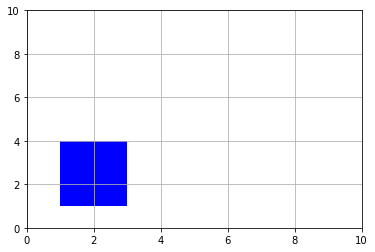

In [7]:
print t #Recall the tower we made
towers = [[t, '#0000ff', None, True]]
plot_towers(towers,10,10)

And we can give it some hatch types too.

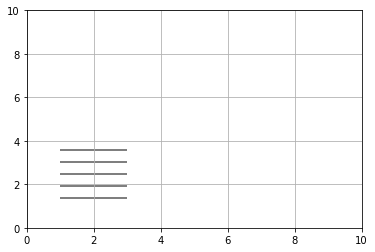

In [8]:
towers = [[t, '#FFFFFF', '-',True]] #Changing color to white.
plot_towers(towers,10,10)

The function can even handle multiple towers.

tower((1, 1),2,3)
tower((4, 2),1,5)
tower((2, 8),6,1)


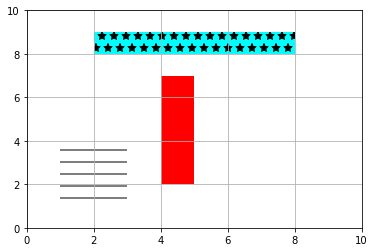

In [9]:
print t
t2 = tower((4,2),1,5) #Feel free to change to widths, heights, and (x,y) coordinate.
t3 = tower((2,8),6,1)
print t2
print t3
towers = [[t, '#FFFFFF', '-',True],[t2, '#FF0000', None, True], [t3, '#00FFFF', '*', True]]
plot_towers(towers,10,10) #Same 10 x 10 desired coverage area

This helped me tremendously when trying to figure out what was happening. Now that we have a reliable way of seeing our towers we can begin discussing the methods available for the class.

## The Various Property Methods In *tower* Class

I have listed them below. The reason why I made them as methods with the *@property* decorator is because when using the *init* method, those values depend on the variables required when creating an instance of a tower. However, if one were to update any of those values, the rest of them (such as area) will not update with the most recent values. Therefore, to save myself some headaches, I opted to use the *@property* decorator which allows me to access the updated values as if it were an attribute of the class instead of a method.

I also made it so the user can use the *__repr__* method to easily reproduce the tower object.

In [10]:
help(tower.area)
help(tower.coord_lr)
help(tower.coord_tr)
help(tower.coord_tl)
help(tower.__repr__)

Help on property:

    Returns the area of the tower's coverage area.
    
    Parameter: The instance of the tower being used to call this method is
                referred to as self.
                
    Type: Instance of class tower.
    
    Return: Returns an integer value for the area.
    
    e.g. 
    >>> t = tower((1, 2),6,4)
    >>> t.area
    24
    
    Returns the area for a given tower object by taking the tower's width 
    (self.width) and a tower's height (self.height) and taking the product.
    
    self.area = self.width * self.height
    
    Assertions: 
        - Can only be used on an instance of tower class.

Help on property:

    Returns lower right corner of tower's coverage area as an (x,y) tuple
    
    Parameter: The instance of the tower being used to call this method is
                referred to as self.
    Type: Instance of class tower.
    
    Return: (x,y) tuple for the lower right corner of tower's coverage area.
    
    e.g. 
    >>> t = t

## The *contained* method
This was the first method I created for this class. I realized early on that I needed a way to be able to check whether one tower object is *contained* in another tower's coverage area.

So the way it is coded is that if a tower is equal too or inside another towers coverage area, then it would produce a list of all True. One True for each corner. So depending on which is True or False, the list will tell you what is contained and what isn't.

In [11]:
help(tower.contained)

Help on method contained in module __main__:

contained(self, other) unbound __main__.tower method
    Checks which corners of a tower (referred to as self) are contained in 
    another tower's (referred to as other) coverage area.
    
    Parameter: self
    Type: tower object
    
    Parameter: other
    Type: tower object
    
    Returns: A list of True or False boolean values. Where each item in the 
    list corresponds to a corner in the following manner.
    
            [LowerLeftCorner,TopLeftCorner,LowerRightCorner,TopRightCorner]
    
    A corner produces a True value if it is inside other's coverage area.
    If the whole list is True, then that means the tower is contained.
    Any Falses mean that the corresponding corner lies outside the bounds 
    of the other's coverage area.
    
    e.g.
    
    >>> t = tower((0,0),2,2)
    >>> z = tower((1,1),2,2)
    >>> z.contained(t) 
    [True, False, False, False]
    >>> #Tells us that the lower left corner is inside t'

So, for example

dashed_box.contained(grey_box) : [False, False, False, True]
star_box.contained(grey_box) : [False, True, False, False]
dot_box.contained(grey_box) : [False, False, True, False]
slash_box.contained(grey_box) : [True, False, False, False]
backslash_box.contained(grey_box) : [True, True, True, True]


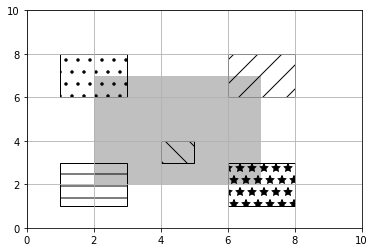

In [12]:
grey_box = tower((2,2),5,5)
dashed_box = tower((1,1),2,2)
star_box = tower((6,1),2,2)
dot_box = tower((1,6),2,2)
slash_box = tower((6,6),2,2)
backslash_box = tower((4,3),1,1)

towers = [[grey_box,'#C0C0C0', None ,True],
          [dashed_box, None,'-',False],
         [star_box, None,'*',False],
         [dot_box,None,'.',False],
         [slash_box,None,'/',False],
         [backslash_box,None,'\\',False],]

plot_towers(towers,10,10)

#"Is dashed_box contained in the grey_box?"
print 'dashed_box.contained(grey_box) :', dashed_box.contained(grey_box)
print 'star_box.contained(grey_box) :', star_box.contained(grey_box)
print 'dot_box.contained(grey_box) :', dot_box.contained(grey_box)
print 'slash_box.contained(grey_box) :', slash_box.contained(grey_box)
print 'backslash_box.contained(grey_box) :', backslash_box.contained(grey_box)

## The __eq__ Method

I quickly realized that the *contained* method, although really helpful in a general sense, is not quite as helpful when trying to figure out whether one tower is equivalent to another. This is due to the fact that a tower can be equal to the bounds of another __and__ also have points that are farther in the other tower's coverage and still yield and all *True* list. Therefore, I used the dunder method __eq__ for determining in very simple syntax whether one tower is equivalent to another.

In [13]:
help(tower.__eq__)

Help on method __eq__ in module __main__:

__eq__(self, other) unbound __main__.tower method
    Checks if one tower is equivalent to another.
    
    Parameter: self
    Type: tower object
    
    Parameter: other
    Type: tower object
    
    Returns: True or False.
    
    e.g.
    >>> t = tower((0,0),2,2)
    >>> z = tower((0,0),2,2)
    >>> t == z
    True
    
    Returns True or False if a tower is equivalent to another tower.
    It does so by checking if the lower left coordinate's, the heights,
    and the widths of both towers match.
    - self.coord_ll == other.coord_ll
    - self.width == other.width
    - self.height == other.height
    
    Assertions:
        - Method can only be used on instances of tower class.



slash_box == grey_box:  True
backslash_box == grey_box:  False


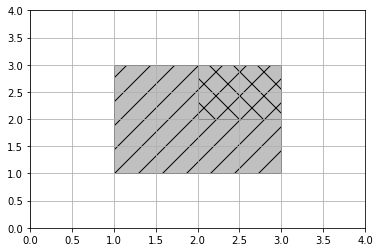

In [14]:
#Lets demonstrate this.
grey_box = tower((1,1),2,2)
slash_box = tower((1,1),2,2)
backslash_box = tower((2,2),1,1)

#"Is t1 equal to t?"
print 'slash_box == grey_box: ', slash_box == grey_box
print 'backslash_box == grey_box: ', backslash_box == grey_box

towers = [[grey_box,'#C0C0C0',None,True],
          [slash_box,None,'/',False],
        [backslash_box,None,'\\',False]]
plot_towers(towers,4,4)

## The *corner* Method
The corner method is similar to that of the *contained* method in that it checks whether the corners of a tower's coverage can be found inside that of another. The main difference is that the *contained* method can detect whether a corner is embedded inside the "wall" of another tower's coverage, while the corner method ignores these. 

This is useful because cases can occur when two towers are hugging but certainly not overlapping. The *contained* method would see that the corners are embedded and if we used the *contained* method to see whether a tower's coverage is valid, we would yield false positives.

In [15]:
help(tower.corner)

Help on method corner in module __main__:

corner(self, other) unbound __main__.tower method
     Checks which corners of a tower are in another tower's coverage area.
     Ignores the bounds of the other tower's coverage area.
     
     Parameter: self
     Type: tower object
     
     Parameter: other
     Type: tower object
     
     Return: A list with four boolean values, each corresponding to a corner of
             the tower (referred to as self), that is inside the tower is is
             being compared to (referred to as other.)
             
             [lowerleftcorner,TopLeftcorner,lowerRightcorner,TopRightcorner]
     
     e.g.
     
     >>> t = tower((0,0),2,2)
     >>> z = tower((1,1),2,2)
     >>> z.corner(t) 
     [True, False, False, False]
     >>> #Tells us that the lower left corner is inside t's coverage.
     
     It does so by checking each corner of a tower's (referred to as self)
     coverage area. For each corner it checks it against the corners of


grey_box.contained(blue_box):  [False, False, True, True]
grey_box.corner(blue_box):  [False, False, False, False]


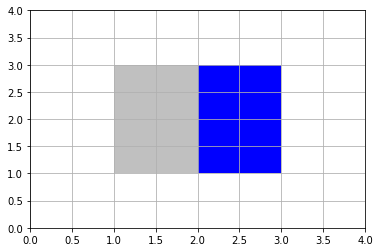

In [16]:
grey_box = tower((1,1),1,2) #gray box
blue_box = tower((2,1),1,2) #blue box

towers = [[grey_box,'#C0C0C0',None,True],
          [blue_box,'#0000FF',None,True]]
plot_towers(towers,4,4)

#Is grey box contained/corner in blue_box?
print 'grey_box.contained(blue_box): ',grey_box.contained(blue_box)
print 'grey_box.corner(blue_box): ', grey_box.corner(blue_box)

As we can see in the plot above, the *corner* method ignores cases that would be considered valid for our project. Namely, when two towers are hugging each other. But it does pick up when corners of a tower are embedded in another tower's coverage area.

dashed_box.corner(grey_box) : [False, False, False, True]
star_box.corner(grey_box) : [False, True, False, False]
dot_box.corner(grey_box) : [False, False, True, False]
slash_box.corner(grey_box) : [True, False, False, False]
backslash_box.corner(grey_box) : [True, True, True, True]


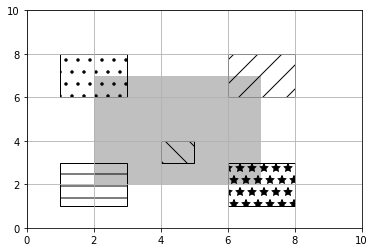

In [17]:
#We can still can pick up the same cases as the contained method, 
#but we exclude the bounds of the tower we are comparing it too.
grey_box = tower((2,2),5,5)
dashed_box = tower((1,1),2,2)
star_box = tower((6,1),2,2)
dot_box = tower((1,6),2,2)
slash_box = tower((6,6),2,2)
backslash_box = tower((4,3),1,1)

towers = [[grey_box,'#C0C0C0', None ,True],
          [dashed_box, None,'-',False],
         [star_box, None,'*',False],
         [dot_box,None,'.',False],
         [slash_box,None,'/',False],
         [backslash_box,None,'\\',False],]

plot_towers(towers,10,10)

#"Does dashed_box contain corners in the grey_box?"
print 'dashed_box.corner(grey_box) :', dashed_box.corner(grey_box)
print 'star_box.corner(grey_box) :', star_box.corner(grey_box)
print 'dot_box.corner(grey_box) :', dot_box.corner(grey_box)
print 'slash_box.corner(grey_box) :', slash_box.corner(grey_box)
print 'backslash_box.corner(grey_box) :', backslash_box.corner(grey_box)

## The *borders* method
As we can see we have good tools to figure out whether a tower's coverage is found in another. However, there is still one more thing that we need that the previous two methods don't quite cover. Say we have a tower whose tower coverage doesn't have any corners inside the other tower's coverage, but they clearly still overlap. Both the *corner* method and *contained* method are blind to these. 

In [18]:
help(tower.borders)

Help on method borders in module __main__:

borders(self, other) unbound __main__.tower method
    Returns whether the left, right, top, or bottom wall of a tower (self) overlaps
    with another tower's (other).
    
    Parameter: self
    Type: tower object
    
    Paramater: other
    Type: tower object
    
    Return: A boolean list with values corresonding to a wall in the following 
            format. True means that the wall is inside another tower's coverage area.
            False means that is is not between the other tower's walls.
            
            [Left Wall, Right Wall, Top Wall, Bottom Wall]
            
    e.g.
    >>> t = tower((0,0),2,2)
    >>> z = tower((1,1),2,2)
    >>> z.borders(t)
    [True, False, False, True] #Left wall and bottom wall are inside.
    
    It does so by checking each wall individually. For the left and right walls,
    it checks whether the x-coordinates of those walls can be found inside
    the region bounded between other's left

line_box.contained(grey_box):  [False, False, False, False]
line_box.corner(grey_box):  [False, False, False, False]


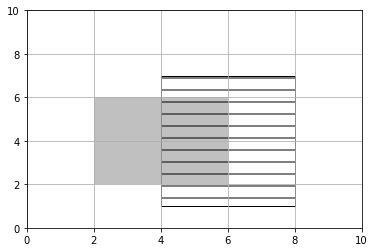

In [19]:
grey_box = tower((2,2),4,4) #gray box
line_box = tower((4,1),4,6) #line box

towers = [[grey_box,'#C0C0C0',None,True],
          [line_box,None,'-',False]]
plot_towers(towers,10,10)

print 'line_box.contained(grey_box): ', line_box.contained(grey_box)
print 'line_box.corner(grey_box): ', line_box.corner(grey_box)

As we can see, clearly the line box is inside the gray box's coverage, but both of our methods fail to pick it up. This is where the *borders* method comes in to help.

The way to think about it is in terms of a tower's walls. If one of those walls is inside another tower's walls, then it gets detected. However, it's really specific in the way it goes about it. It checks whether the left or white walls of our tower have x-values that are between that of the other towers x-values that are bounded by the other tower's left and right walls. It then checks whether the y-values of our tower's left and right walls are within the range of y-values determined by the other tower's top and bottom walls. The conditions for the top and bottom wall are computed in a similar fashion.

The first thing we want is that we want it to ignore valid tower entries. So for cases when the towers are hugging one another, we want to avoid those, which basically describes the situation below.

blue_box.borders(grey_box):  [False, False, False, False]
red_box.borders(grey_box):  [False, False, False, False]
teal_box.borders(grey_box):  [False, False, False, False]
purple_box.borders(grey_box):  [False, False, False, False]


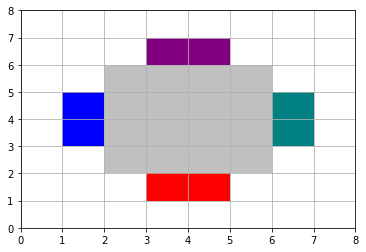

In [20]:
grey_box = tower((2,2),4,4)
blue_box = tower((1,3),1,2)
red_box = tower((3,1),2,1)
teal_box  = tower((6,3),1,2)
purple_box = tower((3,6),2,1)

towers = [[grey_box,'#C0C0C0',None,True],
          [blue_box,'#0000FF',None,True],
           [red_box,'#FF0000',None,True],
           [teal_box,'#008080',None,True],
           [purple_box,'#800080',None,True]
         ]
plot_towers(towers,8,8)

print 'blue_box.borders(grey_box): ', blue_box.borders(grey_box)
print 'red_box.borders(grey_box): ', red_box.borders(grey_box)
print 'teal_box.borders(grey_box): ', teal_box.borders(grey_box)
print 'purple_box.borders(grey_box): ', purple_box.borders(grey_box)

Since the valid tower entries aren't picked up, now we can focus on the ones that it should. Which amounts to two situations.

The first situation involves when either the left or right wall are inside the other tower's coverage.
As we can see it can handle this situation just fine.

slash_box.borders(grey_box):  [False, True, False, False]
star_box.borders(grey_box):  [True, False, False, False]


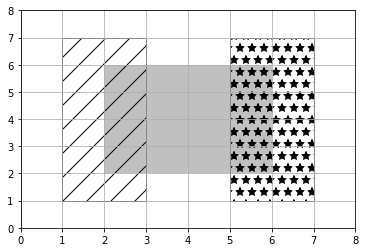

In [21]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,1),2,6)
star_box = tower((5,1),2,6)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
           [star_box,None,'*',False]
         ]
plot_towers(towers,8,8)

print 'slash_box.borders(grey_box): ',slash_box.borders(grey_box)
print 'star_box.borders(grey_box): ',star_box.borders(grey_box)

The second situation is when either the top or bottom wall are embedded. We want to detect those too.

slash_box.borders(grey_box):  [False, False, False, True]
star_box.borders(grey_box):  [False, False, True, False]


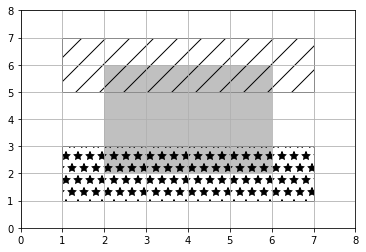

In [22]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,5),6,2)
star_box = tower((1,1),6,2)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
           [star_box,None,'*',False]
         ]
plot_towers(towers,8,8)

print 'slash_box.borders(grey_box): ',slash_box.borders(grey_box)
print 'star_box.borders(grey_box): ',star_box.borders(grey_box)

slash_box.borders(grey_box):  [False, False, True, True]
star_box.borders(grey_box):  [True, True, False, False]


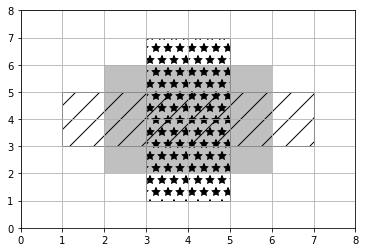

In [23]:
#Showing more walls being inside.
grey_box = tower((2,2),4,4)
slash_box = tower((1,3),6,2)
star_box = tower((3,1),2,6)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
           [star_box,None,'*',False]
         ]
plot_towers(towers,8,8)

print 'slash_box.borders(grey_box): ',slash_box.borders(grey_box)
print 'star_box.borders(grey_box): ',star_box.borders(grey_box)

## The *subtowers* method

Now that we have reliable ways of checking if a tower needs to be truncated or not, now we need a way of constructing a truncated version of that tower.

The way I went about it is by using the tower that I added and using that tower to construct all the possible valid sub-towers that can be contained in that tower's coverage. 

One thing that I learned is that it actually is really time consuming to compute all of the subtowers. Especially when the user wants to populate a large region. 

So I realized that this would be perfect for a generator because we would rather not have to compute the entire list if we don't have too which helps us compute stuff a lot faster. But it isn't enough to have the generator by itself. It matters also to start from the subtower with the largest area and work our way down. This is due to the fact that, the smaller the area is the longer it takes because there are many more possible locations for subtowers with small area than ones with large area so you would have to create all of those, which increases the run time by alot if you have a desired coverage area that is really large. 

In [24]:
help(tower.subtowers)

Help on method subtowers in module __main__:

subtowers(self) unbound __main__.tower method
    Returns a generator object that produces all possible subtowers for a 
    given tower. Starts with subtowers with the largest area and goes down 
    to the subtowers with the smallest area.
    
    Parameter: self
    Type: tower object
    
    Return: generator object that produces a tower's sub-towers.
    
    e.g.
    >>> t = tower((0,0),2,2)
    >>> x = t.subtowers()
    >>> x
    <generator object subtowers at 0x000000000D9B6870>
    >>> for i in x:
    ...    print i
    ...
    tower((0, 0),2,2)
    tower((0, 0),1,2)
    tower((1, 0),1,2)
    tower((0, 0),2,1)
    tower((0, 1),2,1)
    tower((0, 0),1,1)
    tower((1, 0),1,1)
    tower((0, 1),1,1)
    tower((1, 1),1,1)
    
    It starts by taking the tower's width, height, and lower left corner value
    and constructing lists of all possible widths,heights, x-coordinates,
    and y-coordinates. Then it concatenates the widths an

In [25]:
t = tower((0,0),3,2)
x = t.subtowers()
for i in x:
    print i

tower((0, 0),3,2)
tower((0, 0),2,2)
tower((1, 0),2,2)
tower((0, 0),3,1)
tower((0, 1),3,1)
tower((0, 0),1,2)
tower((1, 0),1,2)
tower((2, 0),1,2)
tower((0, 0),2,1)
tower((1, 0),2,1)
tower((0, 1),2,1)
tower((1, 1),2,1)
tower((0, 0),1,1)
tower((1, 0),1,1)
tower((2, 0),1,1)
tower((0, 1),1,1)
tower((1, 1),1,1)
tower((2, 1),1,1)


## The *overlap* method
This was a method that I created by accident in my attempt to create a *truncate* method. Instead of scrapping the code and starting from scratch, I decided to keep it around since it might be useful for other things or for others.

In [26]:
help(tower.overlap)

Help on method overlap in module __main__:

overlap(self, other) unbound __main__.tower method
     Returns the overlap of one tower with another tower as a tower
     object. If no overlap is possible, returns None.
     
     Parameter: self
     Type: tower object
     
     Parameter: other
     Type: tower object
     
     Return: tower object representing the region of overlap.
             If no overlap is found, returns None.
             
     e.g.
     >>> t = tower((0,0),2,2)
     >>> z = tower((1,1),2,2)
     >>> z.overlap(t)
     tower((1, 1),1,1)
     
     Returns the region of overlap by looking for the largest subtower that
     can represent the region of overlap. Due to the fact that when using 
     the subtowers() method, it produces the subtowers with the largest area
     first, that means that the first subtower that, when run through the
     contained method, produces all true, then it would be equal to the region
     of overlap. The use of the generator mak

The way it works is that when the *overlap* method is called, the first thing that happens internally is the *subtowers* method is called. Once that is done, we use the *contained* method to figure out which of those sub-towers are actually inside the other tower's coverage area. Once we have that the sub-towers contained inside the other towers coverage area, we look for the sub-tower with the largest area. Returning it as a tower object proves useful because you can represent that amount of overlap using a tower object and now you know lots of useful information such as the area, where in the grid this overlap occurs, etc.

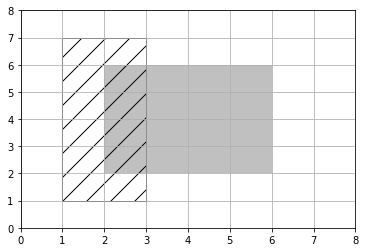

In [27]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,1),2,6)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False]
         ]

plot_towers(towers,8,8)

If we call the *overlap* method on the two objects seen above, we see that we get an overlap of the two objects back as a tower object.

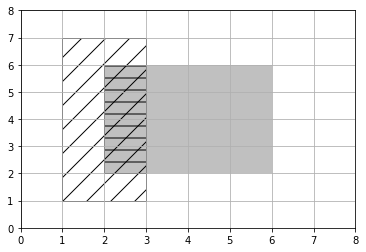

In [28]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,1),2,6)

#"What is the overlap of slash_box with grey_box?"
dash_box = slash_box.overlap(grey_box)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
          [dash_box, None,'-',False]
         ]

plot_towers(towers,8,8)

Not only do I have the overlap, I also know a bunch of useful information relating to that overlap.

In [29]:
print 'Overlap area: ', dash_box.area
print 'Overlap region: '
print '\t x range: %d - %d' % (dash_box.coord_ll[0],dash_box.coord_lr[0])
print '\t y range: %d - %d' % (dash_box.coord_ll[1],dash_box.coord_tl[1])

Overlap area:  4
Overlap region: 
	 x range: 2 - 3
	 y range: 2 - 6


Here's another example.

slash_box.overlap(grey_box):  tower((2, 5),4,1)
dot_box.overlap(grey_box):  tower((2, 2),4,1)


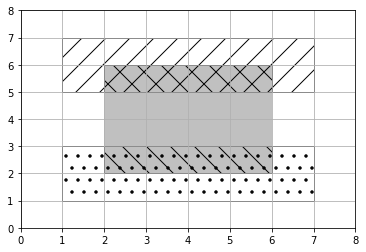

In [31]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,5),6,2)
dot_box = tower((1,1),6,2)

overlap_1 = slash_box.overlap(grey_box)
overlap_2 = dot_box.overlap(grey_box)

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
           [dot_box,None,'.',False],
           [overlap_1,None,'\\',False],
           [overlap_2,None,'\\',False]
         ]
plot_towers(towers,8,8)

print 'slash_box.overlap(grey_box): ',slash_box.overlap(grey_box)
print 'dot_box.overlap(grey_box): ',dot_box.overlap(grey_box)

If no overlap is possible, then the *overlap* method returns *None*.

slash_box.overlap(grey_box) =  None


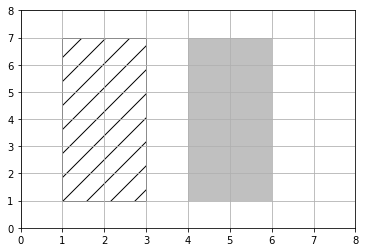

In [32]:
grey_box = tower((4,1),2,6)
slash_box = tower((1,1),2,6)

#"What is the overlap of slash_box with grey_box?"
dash_box = slash_box.overlap(grey_box)

print 'slash_box.overlap(grey_box) = ', dash_box

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
         ]

plot_towers(towers,8,8)

## The *truncate* Method

This is the most important method in the project. It basically does the truncate operation. It uses a lot of the functions that we have already discussed. When you call the function it first starts by calling the *subtowers* method to get all the possible sub-towers for the tower that we are trying to truncate. Then we start filtering our list with some of the other methods. First, it calls the *corner* method to get rid of sub-towers that violate our requirements. Then, we call the *borders* method to get rid of even more sub-lists. The real power in the *truncate* method is that it does this for all the towers that were given when the function was called. It then determines which sub-tower is common to all the towers that have been analyzed. If a sub-tower is common to all the towers we are analyzing against, then that means it is a valid sub-tower. Because the *subtower* method works from largest area to smallest, we end up finding the truncated version pretty efficiently without having to go through every single possible sub-tower.

In [35]:
help(tower.truncate)

Help on method truncate in module __main__:

truncate(self, other) unbound __main__.tower method
    Takes in a list of towers (other) to truncate against and returns a single tower
    object, optimizing new tower for maximum possible area.
    
    Parameter: self
    Type: tower object
    
    Parameter: other
    Type: list, items in this list must be type tower object.
    
    Return: tower object representing truncated version of self maximized
            for largest possible area. If no valid truncated version exists
            against towers found in the list, returns None. If tower does not
            overlap with any found in the list, returns itself.
    
    e.g.
    >>> t = tower((0,0),2,2)
    >>> z = tower((1,1),2,2)
    >>> z.truncate([t])
    tower((2, 1),1,2)
    
    It starts by calling the subtowers() method on self. It starts checking
    subtowers (starting with the largest area) and checks them against all
    towers found in the list (other). It only retur

Lets start with a simple example we have seen before. If we run the *truncate* method against it, we get back the truncated version of the tower.

Original Tower:  tower((1, 1),2,6)
Truncated version:  tower((1, 1),1,6)


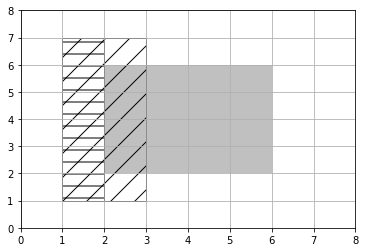

In [36]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,1),2,6)

#"What is the overlap of slash_box with grey_box?"
dash_box = slash_box.truncate([grey_box])

print 'Original Tower: ', slash_box
print 'Truncated version: ', dash_box

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
          [dash_box, None,'-',False]
         ]

plot_towers(towers,8,8)

Let's try another example.

slash_box.truncate([grey_box]):  tower((1, 6),6,1)
dot_box.truncate([grey_box]):  tower((1, 1),6,1)


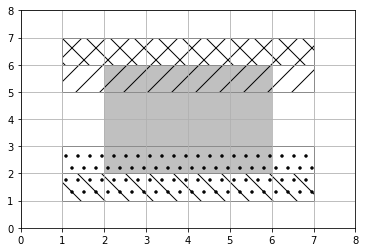

In [38]:
grey_box = tower((2,2),4,4)
slash_box = tower((1,5),6,2)
dot_box = tower((1,1),6,2)

truncate_1 = slash_box.truncate([grey_box])
truncate_2 = dot_box.truncate([grey_box])

towers = [[grey_box,'#C0C0C0',None,True],
           [slash_box, None,'/',False],
           [dot_box,None,'.',False],
           [truncate_1,None,'\\',False],
           [truncate_2,None,'\\',False]
         ]
plot_towers(towers,8,8)

print 'slash_box.truncate([grey_box]): ',slash_box.truncate([grey_box])
print 'dot_box.truncate([grey_box]): ',dot_box.truncate([grey_box])

We can eve run truncate against multiple towers

Truncated tower:  tower((3, 1),2,6)


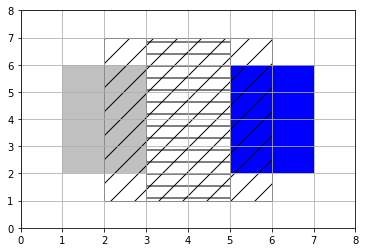

In [39]:
slash_box = tower((2,1),4,6)
grey_box = tower((1,2),2,4)
blue_box = tower((5,2),2,4)

t = [grey_box,blue_box]

dash_box = slash_box.truncate(t)

print 'Truncated tower: ', dash_box

towers = [[grey_box,'#C0C0C0',None,True],
           [blue_box, '#0000FF',None,True],
            [slash_box, None,'/',False],
            [dash_box, None, '-',False],
         ]

plot_towers(towers,8,8)

If a tower doesn't overlap with any others then it returns itself back.

Original tower:  tower((1, 2),2,4)
Truncated tower:  tower((1, 2),2,4)


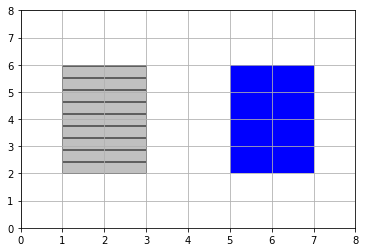

In [40]:
grey_box = tower((1,2),2,4)
blue_box = tower((5,2),2,4)

dash_box = grey_box.truncate([blue_box])

print 'Original tower: ', grey_box
print 'Truncated tower: ', dash_box

towers = [[grey_box,'#C0C0C0',None,True],
          [blue_box,'#0000FF',None,True],
        [dash_box,None,'-',False],
         ]
plot_towers(towers,8,8)

## The *coverage_up_to_n* Function

Now that we have all the tools in place, we can create the function that will do the work desired from the project description. So this function basically takes in a desired coverage area and an amount of towers. From this it randomly generates the towers and plots them or truncates them accordingly until the number of towers asked for has been plotted.

This function has a plotting option so that you can watch what is going on in real-time. It plots a tower attempt as a slash box, and then replaces it with the final version of that tower. 

This function outputs the towers that were generated. If you opted to plot the functions so you can see them, you get a list with your towers in a format that is compatible with the *plot_towers* function. It also outputs a tuple that is in this form. (desired_area,actual_area). This allows us to compare how well we did to cover the entire area.

So first it generates a tower, and because it was randomly generated, we have to verify that it is indeed within the bounds of our plot. We do so by comparing it versus a tower object that represents the desired coverage area that the user wants. We also validate whether or not the newly generated tower is inside another tower or eats up another tower. We check this using the *contained* method.

Once we have validated the tower, we check if it overlaps with the already valid towers. I did this because it is much more efficient to run the truncate method only on the towers that are relevant, despite the fact that the *truncate* method can work with the whole list of already established towers. 

If it doesn't overlap with any of the already established towers, then it is considered valid and it is established.
If there is overlap, we run the *truncate* method on the relevant towers.

Once we have run the truncate method, there are two situations it goes through. Either, the tower gets truncated and is added to the list of established towers. Or there is no valid truncated version for the tower, in which case we try again by generating another random tower.

It does this over and over up to n towers.


In [41]:
import random

color = lambda: random.randint(0,255)
color_rect = '#%02X%02X%02X' % (color(),color(),color())

import numpy as np

def coverage_up_to_n(n,width,height,plot = True, interval = 3):
    '''
    Takes in an amount of towers and a desired coverage area described by a
    height and width and returns a list of randomly generated towers
    to populate the desired coverage area.
    
    Parameter: n
    Type: int
    
    Parameter: width
    Type: int
    
    Parameter: height
    Type: int    
    
    Parameter: plot
    Type: bool
    
    Parameter: interval
    Type: int  
    
    Return:
        - list of towers that populate the coverage area.
        - list of towers that populate the coverage area in a format compatible
            with the function plot_towers().
        - Returns a tuple containing the desired coverage versus the resulting
            coverage given n towers. (desired_area,actual_area)
    e.g.
    >>> valid_towers, plot_list = coverage(10,100,100)
    >>> valid_towers
    [tower((30, 0),15,59),
     tower((7, 1),23,21),
     tower((45, 34),33,44),
     tower((49, 22),2,12),
     tower((15, 32),15,64),
     tower((19, 26),11,6),
     tower((2, 27),13,13),
     tower((53, 78),24,16),
     tower((30, 79),23,12),
     tower((15, 22),2,10)]
    >>> plot_list       
    [[tower((30, 0),15,59), '#56C8D0', None, True],
    [tower((7, 1),23,21), '#1968E5', None, True],
    [tower((45, 34),33,44), '#D23EEB', None, True],
    [tower((49, 22),2,12), '#DFA7A8', None, True],
    [tower((15, 32),15,64), '#A4011A', None, True],
    [tower((19, 26),11,6), '#D47484', None, True],
    [tower((2, 27),13,13), '#58D79F', None, True],
    [tower((53, 78),24,16), '#0E7345', None, True],
    [tower((30, 79),23,12), '#B8131C', None, True],
    [tower((15, 22),2,10), '#239036', None, True]]
    
    
    Assertions:
        - Number of towers (n) must be a positive number.
        - n must be an integer.
        - width must be a positive number
        - width must be an integer.
        - height must be a positive number
        - height must be an integer.   
        - plot must be a boolean, True or False
        - interval must be a positive number
        - interval must be an integer.          
        
    Takes an amount of towers and desired coverage region and randomly generates
    those towers to populate that region. You can opt to watch the attempts take
    place in real time by changing the plot value to True. It will then plot the values
    as time goes on. The variable interval designates the amount of time between plots.
    It starts by generating a random tower with random (x,y) coordinate of the lower
    left corner, a random height and random width. Once the tower is generated
    we check if it's a valid candidate for processing by making sure it is bound
    by the desired coverage region defined by the user. We do this by creating a
    tower that has the dimensions of the whole region. We can then run the contained
    method to see if the randomly generated tower is bound within the desired coverage
    area.
    
    If the current list of valid towers is empty, we add the randomly generated
    into the list.
    
    If it isn't, we makes sure that it isn't completely contained inside any of
    the already established towers, or that our new tower doesn't consume the 
    entirety of the established towers.
    
    Once we have gone through those steps than the tower is valid and we can proceed.
    
    To speed up processing, we only truncate the new tower against towers that it
    overlaps with, which we check with the contained and borders method. If it doesn't
    overlap with any, then we can just add it to the valid tower list.
    
    If there is no valid truncated version of the tower than we toss it out and try
    again. If there is one, we can add it to the valid tower list.
    
    It does this over and over until the confirmed amount of towers is equal to
    the amount of towers asked by the user.
    
    Once we have found all the towers we are finished.
    
    In the plotting mode, it will show the attempted new tower as a slash-box.
    Then it will get replaced with a colored truncated version.
    
    Assertions:
        - n must be a positive integer greater than zero.
        - width must be a positive integer greater than zero.
        - height must be a positive integer greater than zero.
        - plot must be a boolean, True or False
        - interval must be a positive integer greater than zero.
    '''
    assert n > 0, 'Warning! Number of towers must be greater than zero!'
    assert isinstance(n,int), 'Warning! Number of towers must be an integer!'
    assert width > 0, 'Warning! Width of coverage area must be greater than 0!'
    assert isinstance(width,int), 'Warning! Width must be an integer!'
    assert height > 0, 'Warning! Height of coverage area must be greater than 0!'
    assert isinstance(height,int),'Warning! Height must be an integer!'
    assert isinstance(plot,bool), 'Warning! plot must be True or False!'
    assert interval > 0, 'Warning! Interval must be greater than zero!'
    assert isinstance(interval,int), 'Warning! Interval must be an integer!'
    
    print 'Computing...'
    confirmed_towers = 0
    coverage_area = tower((0,0),width,height) #Taking advantage of my tower class method.
    
    valid_towers = []
    plot_list = []
    
    desired_area = width * height
    
    while confirmed_towers < n:
        
        x_rand = np.random.randint(width, size = 1)
        y_rand = np.random.randint(height, size = 1)
        x = x_rand[0]
        y = y_rand[0]
        
        width_rand = np.random.randint(1,width+1, size = 1) #Have to be careful about half-open interval
        height_rand = np.random.randint(1,height+1, size = 1)
        tower_width = width_rand[0]
        tower_height = height_rand[0]
        ###
        t = tower((x,y),tower_width,tower_height)
        
        #Check if newly generated tower is contained in main coverage area.
        test = t.contained(coverage_area)
        valid = 1
        if all(test) != True:
            valid = 0
                
        
        if len(valid_towers) != 0:
            #Checking to see if newly generated tower is inside any of the
            #already established towers.
            for t_i in valid_towers:
                checks = t.contained(t_i)
                if all(checks) == True:
                    valid = 0
            #Checking to see if any of my established towers are inside of mu
            #newly generated tower.
            for t_i in valid_towers:
                checks = t_i.contained(t)
                if all(checks) == True:
                    valid = 0
                    
        #Now that we have validated the new tower, we can proceed.
        if valid == 1:
            #Plotting newly generated tower.
            if plot:
                plot_t = [t,None,'/',False]
                plot_list.append(plot_t)
                plot_towers(plot_list,width,height)
                plt.pause(interval)
                plt.close()
            #If the tower generated is equal to the coverage area, then we are done.
            if (len(valid_towers) == 0) and (t == coverage_area):
                valid_towers.append(t)
                return list_of_towers, plot_list
            elif len(valid_towers) == 0:
                valid_towers.append(t)
                if plot:
                    plot_list.pop()
                    color_rect = '#%02X%02X%02X' % (color(),color(),color())
                    plot_list.append([t,color_rect,None,True])
                confirmed_towers += 1
            else:
                truncate_list = []
                for tow in valid_towers:
                    if any(t.corner(tow)) or any(t.borders(tow)):
                        truncate_list.append(tow)
                        
                if len(truncate_list) != 0:        
                    truncated = t.truncate(truncate_list) #Was valid towers
                    if truncated != None:   
                        if plot:
                            plot_list.pop()
                            color_rect = '#%02X%02X%02X' % (color(),color(),color())
                            plot_list.append([truncated,color_rect,None,True])
                        confirmed_towers += 1
                        valid_towers.append(truncated)
                    else:
                        if plot:
                            plot_list.pop()
                        
                else:
                    if plot:
                        plot_list.pop()
                        color_rect = '#%02X%02X%02X' % (color(),color(),color())
                        plot_list.append([t,color_rect,None,True])
                    confirmed_towers += 1
                    valid_towers.append(t)
                if plot: 
                    if confirmed_towers == n:
                        plot_towers(plot_list,width,height)    
                        
        actual_area = 0
        for coverage in valid_towers:
            actual_area = actual_area + coverage.area
        
        if (actual_area == desired_area):
            print "Coverage area has been filled!"
            break
        
    print 'Desired area: ', desired_area
    print 'Actual area: ', actual_area


    return valid_towers, (desired_area,actual_area), plot_list

So right now I have the function with the plotting enabled. Feel free to disable it if you like. Let's say I want 10 towers to populate a 10 by 10 region. Then it is as simple as doing the following.

Computing...
Desired area:  100
Actual area:  67


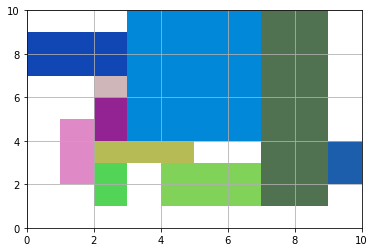

In [42]:
valid_towers, area, plot_list = coverage_up_to_n(10,10,10)

And if we want access to our results, we can just use the variables to get the information we need.

In [43]:
print "Valid Towers:"
for i in valid_towers:
    print '\t',i
print "Plot_list"
for i in plot_list:
    print '\t',i
print '(Desired area = %d, Actual Area = %d)' %(area[0],area[1])

Valid Towers:
	tower((7, 1),2,9)
	tower((2, 3),3,1)
	tower((3, 4),4,6)
	tower((9, 2),1,2)
	tower((0, 7),3,2)
	tower((2, 1),1,2)
	tower((4, 1),3,2)
	tower((1, 2),1,3)
	tower((2, 4),1,2)
	tower((2, 6),1,1)
Plot_list
	[tower((7, 1),2,9), '#507250', None, True]
	[tower((2, 3),3,1), '#B7BB55', None, True]
	[tower((3, 4),4,6), '#0188D8', None, True]
	[tower((9, 2),1,2), '#1C5DAC', None, True]
	[tower((0, 7),3,2), '#1147B5', None, True]
	[tower((2, 1),1,2), '#52D557', None, True]
	[tower((4, 1),3,2), '#80D259', None, True]
	[tower((1, 2),1,3), '#DF89C6', None, True]
	[tower((2, 4),1,2), '#932292', None, True]
	[tower((2, 6),1,1), '#CFB7B9', None, True]
(Desired area = 100, Actual Area = 67)


Due to how to the *subtowers* method works, it can handle pretty large coverage areas pretty well. Although an excercise of patience might be needed, because even though it's decently fast, the larger the desired coverage area, the longer it might to take to find a small valid subtower.

Computing...
Desired area:  10000
Actual area:  3168


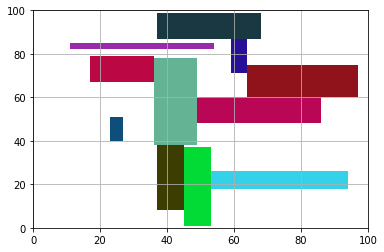

In [44]:
valid_towers, area, plot_list = coverage_up_to_n(11,100,100)

In [45]:
print "Valid Towers:"
for i in valid_towers:
    print '\t',i
print "Plot_list"
for i in plot_list:
    print '\t',i
print '(Desired area = %d, Actual Area = %d)' %(area[0],area[1])

Valid Towers:
	tower((64, 60),33,15)
	tower((59, 71),5,16)
	tower((45, 1),8,36)
	tower((36, 38),13,40)
	tower((11, 82),43,3)
	tower((23, 40),4,11)
	tower((37, 8),8,30)
	tower((53, 18),41,8)
	tower((49, 48),37,12)
	tower((17, 67),19,12)
	tower((37, 87),31,12)
Plot_list
	[tower((64, 60),33,15), '#90131B', None, True]
	[tower((59, 71),5,16), '#280F98', None, True]
	[tower((45, 1),8,36), '#02DA36', None, True]
	[tower((36, 38),13,40), '#63B394', None, True]
	[tower((11, 82),43,3), '#972BA9', None, True]
	[tower((23, 40),4,11), '#0E4E7A', None, True]
	[tower((37, 8),8,30), '#3C3D00', None, True]
	[tower((53, 18),41,8), '#34D2E8', None, True]
	[tower((49, 48),37,12), '#B90755', None, True]
	[tower((17, 67),19,12), '#BB0744', None, True]
	[tower((37, 87),31,12), '#193841', None, True]
(Desired area = 10000, Actual Area = 3168)


# The *average_towers_for_coverage* function

So we can find the coverage for random n towers, but on average, how many towers would it take to cover a region? This is where the *average_towers_for_coverage* function comes in. It is very similar to the *coverage_up_to_n* function but I have taken out the plotting capabilites for the sake of efficiency.

It takes in the number of iterations that you would like to run it for and the desired coverage area. It returns the average back. Not as fancy as the previous function but it does provide a lot of insight as to the amount of towers needed to properly cover a desired coverage area.

It does so by generating towers until the coverage area is properly populated and does so for the amount of iterations the user wants.

In [46]:
def average_towers_for_coverage(iterations,width,height):
    '''
    Takes in an amount of iterations and a desired coverage area described by a
    height and width and returns the average amount of towers needed to fully
    populate the desired coverage area.
    
    Parameter: iterations
    Type: int
    
    Parameter: width
    Type: int
    
    Parameter: height
    Type: int    
    
    Return:
        - Returns the average for the number of iterations asked for by the user.
    e.g.
    
    Assertions:
        - iterations must be a positive number.
        - iterations must be an integer.
        - width must be a positive number
        - width must be an integer.
        - height must be a positive number
        - height must be an integer.            
        
    Takes an amount of iterations and desired coverage region and randomly generates
    those towers to populate that region. 

    It starts by generating a random tower with random (x,y) coordinate of the lower
    left corner, a random height and random width. Once the tower is generated
    we check if it's a valid candidate for processing by making sure it is bound
    by the desired coverage region defined by the user. We do this by creating a
    tower that has the dimensions of the whole region. We can then run the contained
    method to see if the randomly generated tower is bound within the desired coverage
    area.
    
    If the current list of valid towers is empty, we add the randomly generated
    into the list.
    
    If it isn't, we makes sure that it isn't completely contained inside any of
    the already established towers, or that our new tower doesn't consume the 
    entirety of the established towers.
    
    Once we have gone through those steps than the tower is valid and we can proceed.
    
    To speed up processing, we only truncate the new tower against towers that it
    overlaps with, which we check with the contained and borders method. If it doesn't
    overlap with any, then we can just add it to the valid tower list.
    
    If there is no valid truncated version of the tower than we toss it out and try
    again. If there is one, we can add it to the valid tower list.
    
    It does this over and over until the confirmed amount of towers is equal to
    the amount of towers asked by the user.
    
    Once we have found all the towers we are finished and we go to the next iteration.
    It does this until all the iterations are done.
    
    
    
    Assertions:
        - iterations must be a positive integer greater than zero.
        - width must be a positive integer greater than zero.
        - height must be a positive integer greater than zero.

    '''
    assert iterations > 0, 'Warning! Number of iterations must be greater than zero!'
    assert isinstance(iterations,int), 'Warning! Number of iterations must be an integer!'
    assert width > 0, 'Warning! Width of coverage area must be greater than 0!'
    assert isinstance(width,int), 'Warning! Width must be an integer!'
    assert height > 0, 'Warning! Height of coverage area must be greater than 0!'
    assert isinstance(height,int),'Warning! Height must be an integer!'
    
    print 'Computing...'
    confirmed_towers = 0
    coverage_area = tower((0,0),width,height) #Taking advantage of my tower class method.
    
    desired_area = width * height
    counter = 0
    number_of_towers = []
    
    while counter < iterations:
        actual_area = 0
        valid_towers = []
        while actual_area != desired_area:
            x_rand = np.random.randint(width, size = 1)
            y_rand = np.random.randint(height, size = 1)
            x = x_rand[0]
            y = y_rand[0]
            
            width_rand = np.random.randint(1,width+1, size = 1) #Have to be careful about half-open interval
            height_rand = np.random.randint(1,height+1, size = 1)
            tower_width = width_rand[0]
            tower_height = height_rand[0]
            ###
            t = tower((x,y),tower_width,tower_height)
            
            #Check if newly generated tower is contained in main coverage area.
            test = t.contained(coverage_area)
            valid = 1
            if all(test) != True:
                valid = 0
                    
            
            if len(valid_towers) != 0:
                #Checking to see if newly generated tower is inside any of the
                #already established towers.
                for t_i in valid_towers:
                    checks = t.contained(t_i)
                    if all(checks) == True:
                        valid = 0
                #Checking to see if any of my established towers are inside of mu
                #newly generated tower.
                for t_i in valid_towers:
                    checks = t_i.contained(t)
                    if all(checks) == True:
                        valid = 0
                        
            #Now that we have validated the new tower, we can proceed.
            if valid == 1:
                #If the tower generated is equal to the coverage area, then we are done.
                if (len(valid_towers) == 0) and (t == coverage_area):
                    valid_towers.append(t)
                    return list_of_towers, plot_list
                elif len(valid_towers) == 0:
                    valid_towers.append(t)
                    confirmed_towers += 1
                else:
                    truncate_list = []
                    for tow in valid_towers:
                        if any(t.corner(tow)) or any(t.borders(tow)):
                            truncate_list.append(tow)
                            
                    if len(truncate_list) != 0:        
                        truncated = t.truncate(truncate_list) #Was valid towers
                        if truncated != None:   
                            confirmed_towers += 1
                            valid_towers.append(truncated)                        
                    else:
                        confirmed_towers += 1
                        valid_towers.append(t)  
                            
            actual_area = 0
            for coverage in valid_towers:
                actual_area = actual_area + coverage.area
            
            if (actual_area == desired_area):
                print 'Iteration: %d. Desired coverage area has been filled!' % (counter+1)
                break
            
        number_of_towers.append(len(valid_towers))
        counter += 1
    
    summation = float(sum(number_of_towers))
    average = summation / len(number_of_towers)
    
    print "Number of iterations: ", iterations
    print "Average: ", average    
    
    return average

For example, lets say I want to find out the average amount of towers I would need to populate a 10 by 10 region and I want to run this 10 times. Then you can do it in the following manner.

Note: It can be really slow depending on the size of the desired coverage region and the amount of times you want to run it for.

In [47]:
average_towers_for_coverage(10,10,10)

Computing...
Iteration: 1. Desired coverage area has been filled!
Iteration: 2. Desired coverage area has been filled!
Iteration: 3. Desired coverage area has been filled!
Iteration: 4. Desired coverage area has been filled!
Iteration: 5. Desired coverage area has been filled!
Iteration: 6. Desired coverage area has been filled!
Iteration: 7. Desired coverage area has been filled!
Iteration: 8. Desired coverage area has been filled!
Iteration: 9. Desired coverage area has been filled!
Iteration: 10. Desired coverage area has been filled!
Number of iterations:  10
Average:  31.7


31.7

Let's try an unsual shape for once. Say I want to find out the average amount of towers I would need to cover a 8 by 20 region and run it 10 times.

In [49]:
average_towers_for_coverage(10,8,20)

Computing...
Iteration: 1. Desired coverage area has been filled!
Iteration: 2. Desired coverage area has been filled!
Iteration: 3. Desired coverage area has been filled!
Iteration: 4. Desired coverage area has been filled!
Iteration: 5. Desired coverage area has been filled!
Iteration: 6. Desired coverage area has been filled!
Iteration: 7. Desired coverage area has been filled!
Iteration: 8. Desired coverage area has been filled!
Iteration: 9. Desired coverage area has been filled!
Iteration: 10. Desired coverage area has been filled!
Number of iterations:  10
Average:  37.8


37.8

It works, but already we can see the downside of having to compute the subtowers. It can make things really slow if it has to look for a subtower that has a small area. That and the fact that we don't get to decide where to place a tower since it is randomly generated also affects the run time of something like this.

# test_tower_class.py
I figured I should dedicated a section of the notebook to the test class I used to make sure I didn't break anything by accident when working on the tower class. It makes use of the *unittest* module, which is a standard for Python and I used it to test the individual methods of the class. I did so by figuring out some of the cases by hand and using the this code to verify that my code is indeed working. For the *subtowers* method, I generated a list once when I knew it was working properly and I tested the results against that to make sure I didn't break anything when I decided to change it into a generator.

It's pretty long, but you've actually seen the test cases that I used while reading this notebook. Those were the cases that I used to make sure that it works.

In [50]:
#Author: Humberto Hernandez
#Last updated: 5/19/2018 7:44pm
import unittest

class TestTowerClass(unittest.TestCase):
    '''
    Used to make sure that the tower class is working properly.
    Please run in the same directory containing the following files. 
    Please run as main file!
    
    - plotting_code_proj.py
    - tower_class.py
    - tower_coverage.py
    
    This code tests the following methods from the tower class.
    - __eq__
    - contained()
    - corner()
    - borders()
    - overlap()
    - subtowers()
    - truncate()
    
    '''
    
    def setUp(self):
        '''
        Sets up typical towers.
        
        t1 = tower((2,2),4,6)
        t2 = tower((7,2),2,6)
        other = [t1,t2]
        '''
        self.t1 = tower((2,2),4,6)
        self.t2 = tower((7,2),2,6)
        self.other = [self.t1,self.t2]
        
    def test___eq__(self):
        '''
        Tests the __eq__ method from the tower class.
        
        Test is, given two identical towers, does it recognize that they are
        equivalent?
        '''
        t_test = tower((2,2),4,6)
        result = t_test == self.t1
        self.assertEqual(result,True)
        
    def test_contained(self):
        '''
        Tests the contained method from the tower class.
        
        Tests typical situations seen by the contained method. This test case
        can be found in the Juypter Notebook section discussing the contained method.
        
        Consists of:
            - Can identify specific corners.
            - Can recognize when one tower is contained in another.
        '''
        grey_box = tower((2,2),5,5)
        dashed_box = tower((1,1),2,2)
        star_box = tower((6,1),2,2)
        dot_box = tower((1,6),2,2)
        slash_box = tower((6,6),2,2)
        backslash_box = tower((4,3),1,1)
        
        result_1 = dashed_box.contained(grey_box)
        result_2 = star_box.contained(grey_box)
        result_3 = dot_box.contained(grey_box)
        result_4 = slash_box.contained(grey_box)
        result_5 = backslash_box.contained(grey_box)
        
        self.assertEqual(result_1,[False,False,False,True])
        self.assertEqual(result_2,[False,True,False,False])
        self.assertEqual(result_3,[False,False,True,False])                
        self.assertEqual(result_4,[True,False,False,False])
        self.assertEqual(result_5,[True,True,True,True])
        
    
    def test_corner(self):
        '''
        Tests the corner method from the tower class.
        
        Tests typical situations seen by the corner method. This test case
        can be found in the Juypter Notebook section discussing the corner method.
        
        Consists of:
            - Can identify specific corners.
            - Can recognize when one tower is contained in another.
        '''
        grey_box = tower((1,1),1,2) #gray box
        blue_box = tower((2,1),1,2) #blue box
        result_1 = grey_box.corner(blue_box)
        
        self.assertEqual(result_1,[False, False, False, False])
        
        grey_box = tower((2,2),5,5)
        dashed_box = tower((1,1),2,2)
        star_box = tower((6,1),2,2)
        dot_box = tower((1,6),2,2)
        slash_box = tower((6,6),2,2)
        backslash_box = tower((4,3),1,1)
        
        result_1 = dashed_box.corner(grey_box)
        result_2 = star_box.corner(grey_box)
        result_3 = dot_box.corner(grey_box)
        result_4 = slash_box.corner(grey_box)
        result_5 = backslash_box.corner(grey_box)
        
        self.assertEqual(result_1,[False,False,False,True])
        self.assertEqual(result_2,[False,True,False,False])
        self.assertEqual(result_3,[False,False,True,False])                
        self.assertEqual(result_4,[True,False,False,False])
        self.assertEqual(result_5,[True,True,True,True])

       
    def test_borders(self):
        '''
        Tests the border method from the tower class.
        
        Tests typical cases seen by the borders method. The cases this tests can
        be found in the Juypter Notebook section discussing the borders method.
        
        Consists of:
            - Can it tell which wall(s) is inside a region of another tower's
                coverage.
        '''
        grey_box = tower((2,2),4,4)
        t_test =[tower((1,3),1,2),tower((3,1),2,1),tower((6,3),1,2),tower((3,6),2,1)]

        for t in t_test:
            result = t.borders(grey_box)
            self.assertEqual(result,[False,False,False,False])
          
        slash_box = tower((1,1),2,6)
        star_box = tower((5,1),2,6)
         
        result_1 = slash_box.borders(grey_box)
        result_2 = star_box.borders(grey_box)
         
        self.assertEqual(result_1,[False,True,False,False])
        self.assertEqual(result_2,[True,False,False,False])
        
        slash_box = tower((1,5),6,2)
        star_box = tower((1,1),6,2)
        
        result_3 = slash_box.borders(grey_box)
        result_4 = star_box.borders(grey_box)
         
        self.assertEqual(result_3,[False,False,False,True])
        self.assertEqual(result_4,[False,False,True,False])
        
        slash_box = tower((1,3),6,2)
        star_box = tower((3,1),2,6)
        
        result_3 = slash_box.borders(grey_box)
        result_4 = star_box.borders(grey_box)
         
        self.assertEqual(result_3,[False,False,True,True])
        self.assertEqual(result_4,[True,True,False,False])

    def test_overlap(self):
        '''
        Tests the overlap method found in the tower class.
        
        Tests typical cases that overlap is used for. The various
        cases can be found in the Juypter Notebook dicsussing the overlap
        method.
        
        Consists of
        - Can it return the right tower object for the case in question.
        '''
        grey_box = tower((2,2),4,4)
        slash_box = tower((1,1),2,6)
        
        result = slash_box.overlap(grey_box)
        self.assertEqual(result.area,4)
        self.assertEqual(result.coord_ll,(2,2))
        self.assertEqual(result.width,1)
        self.assertEqual(result.height,4)
        
        slash_box = tower((1,5),6,2)
        star_box = tower((1,1),6,2)
        
        overlap_1 = slash_box.overlap(grey_box)
        overlap_2 = star_box.overlap(grey_box)

        self.assertEqual(overlap_1.coord_ll,(2,5))
        self.assertEqual(overlap_1.width,4)
        self.assertEqual(overlap_1.height,1)
        
        self.assertEqual(overlap_2.coord_ll,(2,2))
        self.assertEqual(overlap_2.width,4)
        self.assertEqual(overlap_2.height,1)
        
        grey_box = tower((4,1),2,6)
        slash_box = tower((1,1),2,6)
        dash_box = slash_box.overlap(grey_box)
        
        self.assertEqual(dash_box,None)
        
    def test_subtowers(self):
        '''
        Tests for the subtowers() method found in the tower class.
        
        Test a typical case used for subtower. We create a tower and check the
        resulting list against the list that it should generate.
        '''
        t = tower((0,0),5,5)
        test = [tower((0, 0),1,1),
                 tower((0, 0),1,2),
                 tower((0, 0),1,3),
                 tower((0, 0),1,4),
                 tower((0, 0),1,5),
                 tower((0, 0),2,1),
                 tower((0, 0),2,2),
                 tower((0, 0),2,3),
                 tower((0, 0),2,4),
                 tower((0, 0),2,5),
                 tower((0, 0),3,1),
                 tower((0, 0),3,2),
                 tower((0, 0),3,3),
                 tower((0, 0),3,4),
                 tower((0, 0),3,5),
                 tower((0, 0),4,1),
                 tower((0, 0),4,2),
                 tower((0, 0),4,3),
                 tower((0, 0),4,4),
                 tower((0, 0),4,5),
                 tower((0, 0),5,1),
                 tower((0, 0),5,2),
                 tower((0, 0),5,3),
                 tower((0, 0),5,4),
                 tower((0, 0),5,5),
                 tower((0, 1),1,1),
                 tower((0, 1),1,2),
                 tower((0, 1),1,3),
                 tower((0, 1),1,4),
                 tower((0, 1),2,1),
                 tower((0, 1),2,2),
                 tower((0, 1),2,3),
                 tower((0, 1),2,4),
                 tower((0, 1),3,1),
                 tower((0, 1),3,2),
                 tower((0, 1),3,3),
                 tower((0, 1),3,4),
                 tower((0, 1),4,1),
                 tower((0, 1),4,2),
                 tower((0, 1),4,3),
                 tower((0, 1),4,4),
                 tower((0, 1),5,1),
                 tower((0, 1),5,2),
                 tower((0, 1),5,3),
                 tower((0, 1),5,4),
                 tower((0, 2),1,1),
                 tower((0, 2),1,2),
                 tower((0, 2),1,3),
                 tower((0, 2),2,1),
                 tower((0, 2),2,2),
                 tower((0, 2),2,3),
                 tower((0, 2),3,1),
                 tower((0, 2),3,2),
                 tower((0, 2),3,3),
                 tower((0, 2),4,1),
                 tower((0, 2),4,2),
                 tower((0, 2),4,3),
                 tower((0, 2),5,1),
                 tower((0, 2),5,2),
                 tower((0, 2),5,3),
                 tower((0, 3),1,1),
                 tower((0, 3),1,2),
                 tower((0, 3),2,1),
                 tower((0, 3),2,2),
                 tower((0, 3),3,1),
                 tower((0, 3),3,2),
                 tower((0, 3),4,1),
                 tower((0, 3),4,2),
                 tower((0, 3),5,1),
                 tower((0, 3),5,2),
                 tower((0, 4),1,1),
                 tower((0, 4),2,1),
                 tower((0, 4),3,1),
                 tower((0, 4),4,1),
                 tower((0, 4),5,1),
                 tower((1, 0),1,1),
                 tower((1, 0),1,2),
                 tower((1, 0),1,3),
                 tower((1, 0),1,4),
                 tower((1, 0),1,5),
                 tower((1, 0),2,1),
                 tower((1, 0),2,2),
                 tower((1, 0),2,3),
                 tower((1, 0),2,4),
                 tower((1, 0),2,5),
                 tower((1, 0),3,1),
                 tower((1, 0),3,2),
                 tower((1, 0),3,3),
                 tower((1, 0),3,4),
                 tower((1, 0),3,5),
                 tower((1, 0),4,1),
                 tower((1, 0),4,2),
                 tower((1, 0),4,3),
                 tower((1, 0),4,4),
                 tower((1, 0),4,5),
                 tower((1, 1),1,1),
                 tower((1, 1),1,2),
                 tower((1, 1),1,3),
                 tower((1, 1),1,4),
                 tower((1, 1),2,1),
                 tower((1, 1),2,2),
                 tower((1, 1),2,3),
                 tower((1, 1),2,4),
                 tower((1, 1),3,1),
                 tower((1, 1),3,2),
                 tower((1, 1),3,3),
                 tower((1, 1),3,4),
                 tower((1, 1),4,1),
                 tower((1, 1),4,2),
                 tower((1, 1),4,3),
                 tower((1, 1),4,4),
                 tower((1, 2),1,1),
                 tower((1, 2),1,2),
                 tower((1, 2),1,3),
                 tower((1, 2),2,1),
                 tower((1, 2),2,2),
                 tower((1, 2),2,3),
                 tower((1, 2),3,1),
                 tower((1, 2),3,2),
                 tower((1, 2),3,3),
                 tower((1, 2),4,1),
                 tower((1, 2),4,2),
                 tower((1, 2),4,3),
                 tower((1, 3),1,1),
                 tower((1, 3),1,2),
                 tower((1, 3),2,1),
                 tower((1, 3),2,2),
                 tower((1, 3),3,1),
                 tower((1, 3),3,2),
                 tower((1, 3),4,1),
                 tower((1, 3),4,2),
                 tower((1, 4),1,1),
                 tower((1, 4),2,1),
                 tower((1, 4),3,1),
                 tower((1, 4),4,1),
                 tower((2, 0),1,1),
                 tower((2, 0),1,2),
                 tower((2, 0),1,3),
                 tower((2, 0),1,4),
                 tower((2, 0),1,5),
                 tower((2, 0),2,1),
                 tower((2, 0),2,2),
                 tower((2, 0),2,3),
                 tower((2, 0),2,4),
                 tower((2, 0),2,5),
                 tower((2, 0),3,1),
                 tower((2, 0),3,2),
                 tower((2, 0),3,3),
                 tower((2, 0),3,4),
                 tower((2, 0),3,5),
                 tower((2, 1),1,1),
                 tower((2, 1),1,2),
                 tower((2, 1),1,3),
                 tower((2, 1),1,4),
                 tower((2, 1),2,1),
                 tower((2, 1),2,2),
                 tower((2, 1),2,3),
                 tower((2, 1),2,4),
                 tower((2, 1),3,1),
                 tower((2, 1),3,2),
                 tower((2, 1),3,3),
                 tower((2, 1),3,4),
                 tower((2, 2),1,1),
                 tower((2, 2),1,2),
                 tower((2, 2),1,3),
                 tower((2, 2),2,1),
                 tower((2, 2),2,2),
                 tower((2, 2),2,3),
                 tower((2, 2),3,1),
                 tower((2, 2),3,2),
                 tower((2, 2),3,3),
                 tower((2, 3),1,1),
                 tower((2, 3),1,2),
                 tower((2, 3),2,1),
                 tower((2, 3),2,2),
                 tower((2, 3),3,1),
                 tower((2, 3),3,2),
                 tower((2, 4),1,1),
                 tower((2, 4),2,1),
                 tower((2, 4),3,1),
                 tower((3, 0),1,1),
                 tower((3, 0),1,2),
                 tower((3, 0),1,3),
                 tower((3, 0),1,4),
                 tower((3, 0),1,5),
                 tower((3, 0),2,1),
                 tower((3, 0),2,2),
                 tower((3, 0),2,3),
                 tower((3, 0),2,4),
                 tower((3, 0),2,5),
                 tower((3, 1),1,1),
                 tower((3, 1),1,2),
                 tower((3, 1),1,3),
                 tower((3, 1),1,4),
                 tower((3, 1),2,1),
                 tower((3, 1),2,2),
                 tower((3, 1),2,3),
                 tower((3, 1),2,4),
                 tower((3, 2),1,1),
                 tower((3, 2),1,2),
                 tower((3, 2),1,3),
                 tower((3, 2),2,1),
                 tower((3, 2),2,2),
                 tower((3, 2),2,3),
                 tower((3, 3),1,1),
                 tower((3, 3),1,2),
                 tower((3, 3),2,1),
                 tower((3, 3),2,2),
                 tower((3, 4),1,1),
                 tower((3, 4),2,1),
                 tower((4, 0),1,1),
                 tower((4, 0),1,2),
                 tower((4, 0),1,3),
                 tower((4, 0),1,4),
                 tower((4, 0),1,5),
                 tower((4, 1),1,1),
                 tower((4, 1),1,2),
                 tower((4, 1),1,3),
                 tower((4, 1),1,4),
                 tower((4, 2),1,1),
                 tower((4, 2),1,2),
                 tower((4, 2),1,3),
                 tower((4, 3),1,1),
                 tower((4, 3),1,2),
                 tower((4, 4),1,1)]
        subtowers = t.subtowers()
        generated = list(subtowers)
        
        self.assertEqual(len(test), len(generated))
        
        for subtower in test:
            saw_it = 0
            for t in generated:
                if t == subtower:
                    saw_it = 1
            self.assertEqual(saw_it, 1)
            
        
        
    def test_truncate(self):
        '''
        Tests the truncate method from the tower class.
        
        Tests typical cases that the truncate method would be used for. The
        cases can be found in the Juypter Notebook section discussing the
        truncate method.
        
        Tests the result against the truncated tower it should generate if
        working properly.
        '''
        grey_box = tower((2,2),4,4)
        slash_box = tower((1,1),2,6)

        dash_box = slash_box.truncate([grey_box])

        self.assertEqual(dash_box.coord_ll,(1,1))
        self.assertEqual(dash_box.width,1)
        self.assertEqual(dash_box.height,6)

        grey_box = tower((2,2),4,4)
        slash_box = tower((1,5),6,2)
        star_box = tower((1,1),6,2)
        
        truncate_1 = slash_box.truncate([grey_box])
        truncate_2 = star_box.truncate([grey_box])
        
        self.assertEqual(truncate_1.coord_ll,(1,6))
        self.assertEqual(truncate_1.width,6)
        self.assertEqual(truncate_1.height,1)

        self.assertEqual(truncate_2.coord_ll,(1,1))
        self.assertEqual(truncate_2.width,6)
        self.assertEqual(truncate_2.height,1)
        
        slash_box = tower((2,1),4,6)
        grey_box = tower((1,2),2,4)
        blue_box = tower((5,2),2,4)
        
        t = [grey_box,blue_box]
        
        dash_box = slash_box.truncate(t)
        
        self.assertEqual(dash_box.coord_ll,(3,1))
        self.assertEqual(dash_box.width,2)
        self.assertEqual(dash_box.height,6)
        
        grey_box = tower((1,2),2,4)
        blue_box = tower((5,2),2,4)
        
        dash_box = grey_box.truncate([blue_box])
        
        self.assertEqual(dash_box.coord_ll,(1,2))
        self.assertEqual(dash_box.width,2)
        self.assertEqual(dash_box.height,4)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignore'], exit = False)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.126s

OK


# Resources
Here's a list of resources that I used to help create this project.

## Matplotlib 
The resources I used to figure out how to plot the towers.
1. https://matplotlib.org/api/_as_gen/matplotlib.patches.Rectangle.html#matplotlib.patches.Rectangle
2. https://matplotlib.org/users/pyplot_tutorial.html
3. https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.add_patch.html
4. https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
5. https://matplotlib.org/tutorials/colors/colors.html#sphx-glr-tutorials-6. colors-colors-py

## Python Related Help 
These are the resources I found to help me with really specific problems I couldn't figure out on my own. 
1. https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.randint.html
https://stackoverflow.com/questions/1207406/how-to-remove-items-from-a-list-while-iterating
2. http://treyhunner.com/2016/11/check-whether-all-items-match-a-condition-in-python/
3. https://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python
4. https://stackoverflow.com/questions/8213522/when-to-use-cla-clf-or-close-for-clearing-a-plot-in-matplotlib
5. https://stackoverflow.com/questions/403421/how-to-sort-a-list-of-objects-based-on-an-attribute-of-the-objects
6. https://www.digitalocean.com/community/tutorials/how-to-use-break-continue-and-pass-statements-when-working-with-loops-in-python-3
7. https://softwareengineering.stackexchange.com/questions/112463/why-do-iterators-in-python-raise-an-exception
8. https://stackoverflow.com/questions/19556940/sort-an-array-of-tuples-by-product-in-python
9. https://stackoverflow.com/questions/21293336/python-break-out-of-all-loops/21293486

## Python Modules:
Really helpful modules that I ended up using for the project.
1. https://docs.python.org/3/library/unittest.html
2. https://docs.python.org/2/library/itertools.html

## Useful Videos and Video Series
1. https://www.youtube.com/watch?v=ZDa-Z5JzLYM - Python Object Oriented Programming by Corey Schafer
2. https://www.youtube.com/watch?v=6tNS--WetLI - Unittest tutorial by Corey Schafer
3. https://www.youtube.com/watch?v=HW29067qVWk - Juypter Notebook Tutorial by Corey Schafer